In [1]:
#Setup and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
import warnings


#configuration
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
plt.style.use('seaborn-v0_8')

#constants 
DATA_PATH = Path("dataset/train.csv")
VIZ_PATH = Path("visualizations")
VIZ_PATH.mkdir(exist_ok=True)

COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

In [2]:
#Utility Functions

def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data(DATA_PATH)


def get_missing_summary(df):
    missing_data = []
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            missing_data.append({
                'feature' : col,
                'missing_count' : df[col].isnull().sum(),
                'missing_pct' : round(df[col].isnull().mean() * 100, 2)
            })
    
    if missing_data:
        return pd.DataFrame(missing_data).sort_values('missing_pct', ascending=False)
    return pd.DataFrame()

missing_summary = get_missing_summary(df)

features = missing_summary['feature'].tolist()

def plot_missing_impact(df, features, target='SalePrice' , max_features = 6):
    features_to_plot = features[:max_features]

    fig,axes = plt.subplots(2,3, figsize=(15,16))
    fig.suptitle('Missing Values Impact on Sale Price', fontsize=14)
    axes = axes.ravel()

    for i,feature in enumerate(features_to_plot):
        data = df.copy()
        data['is_missing'] = data[feature].isnull().astype(int)

        median_prices = data.groupby('is_missing')[target].sum()

        axes[i].bar(['Present', 'Missing'],
                   [median_prices[0], median_prices[1]],
                   color = COLORS[:2])
        axes[i].set_title(feature)
        axes[i].set_ylabel('Median Price')

    for j, v in enumerate([median_prices[0], median_prices[1]]):
        axes[i].text(j, v, f'${v:,.0f}', ha='center', va='bottom')

    for i in range(len(features_to_plot), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig(VIZ_PATH / 'missing_impact.png', dpi=300, bbox_inches='tight')
    plt.show()


Data loaded: (1460, 81)


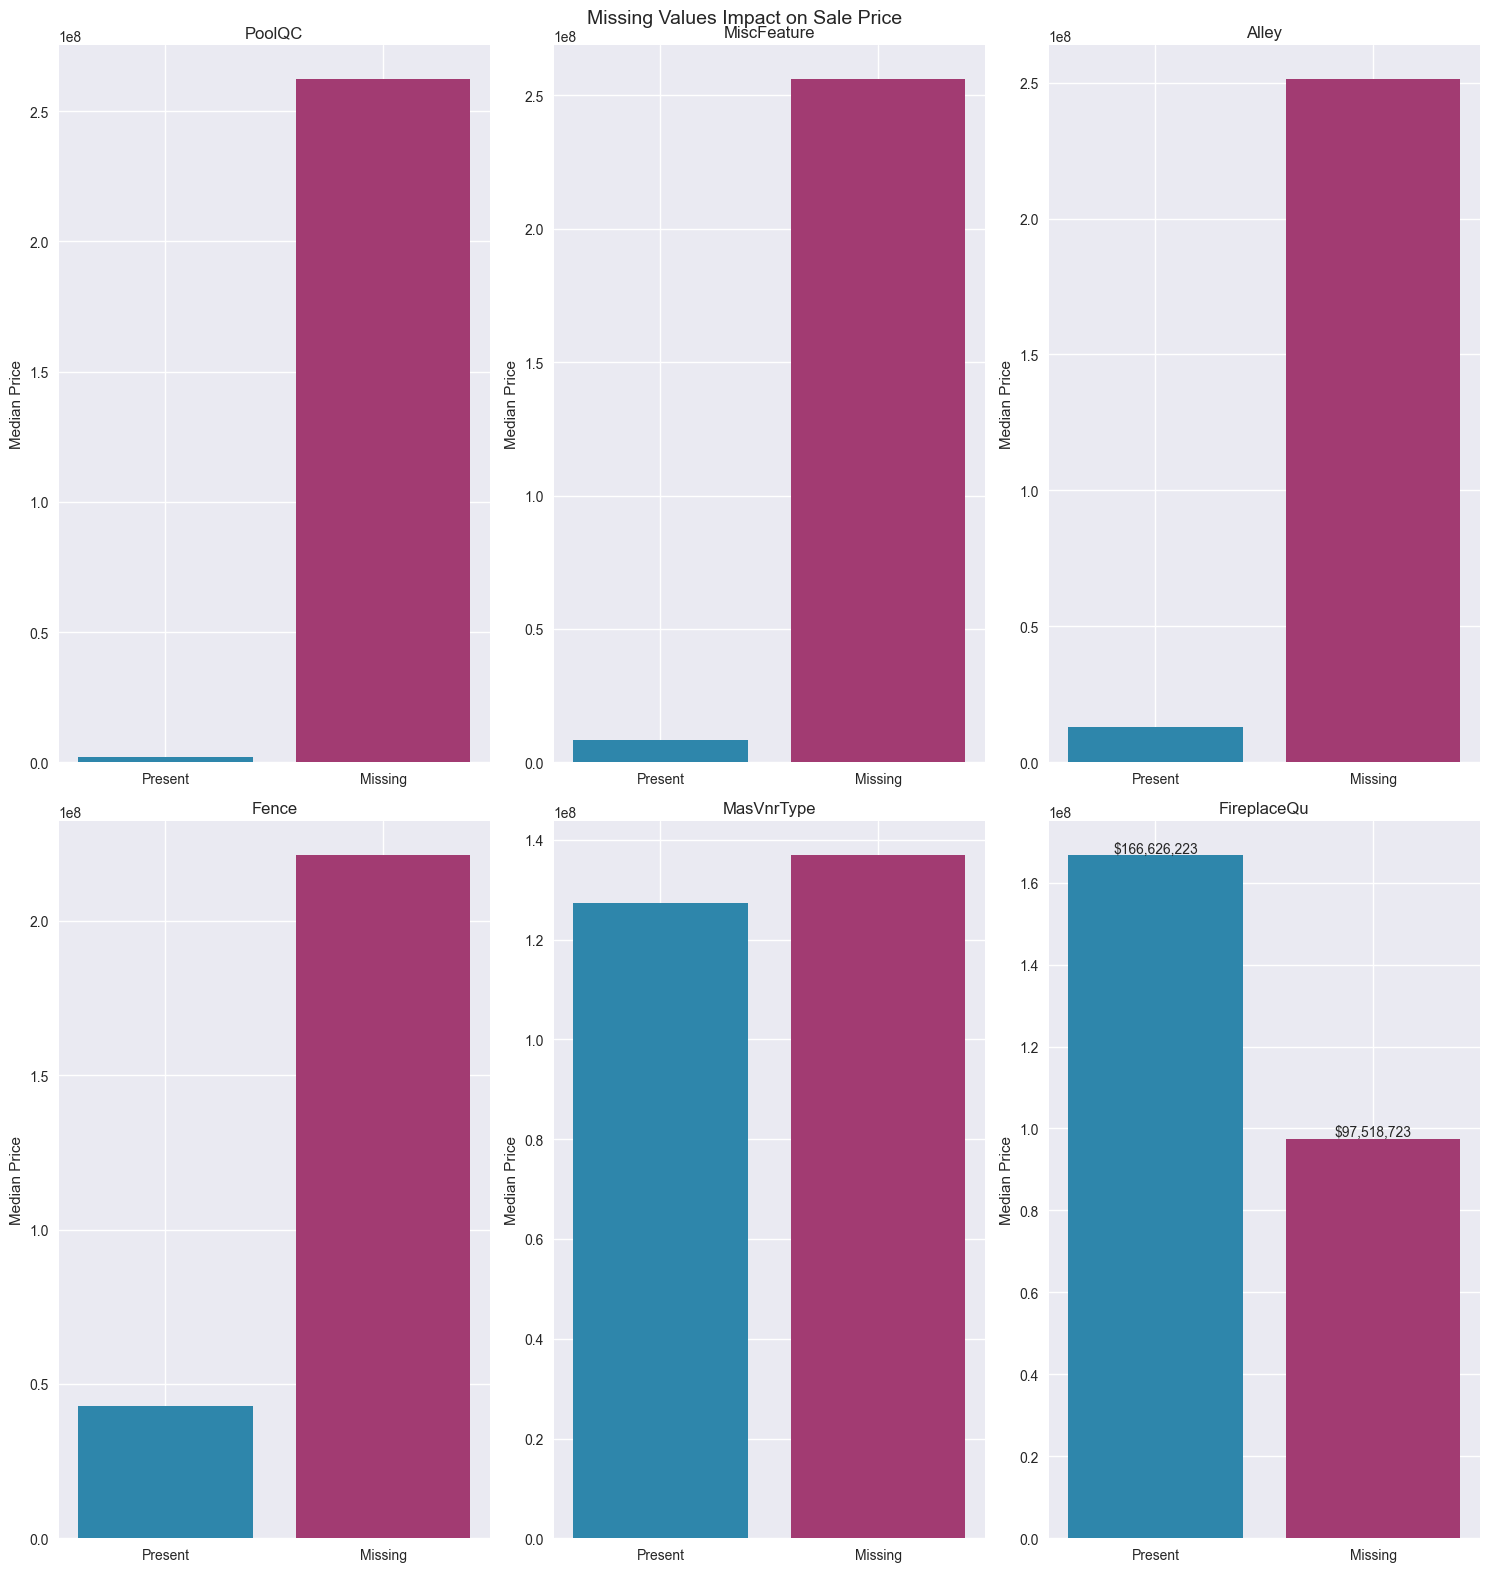

In [17]:
plot_missing_impact(df, features, target='SalePrice' , max_features = 6)

In [14]:
def get_feature_types(df):
    """Categorize features by type"""
    numerical = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical = df.select_dtypes(include=['object']).columns.tolist()
    temporal = [col for col in numerical if 'yr' in col.lower() or  'year' in col.lower()]

    return{
        'numerical': numerical,
        'categorical': categorical,
        'temporal': temporal
    }

def analyze_temporal_trends(df, temporal_features, target= 'SalePrice'):
    if 'YrSold' not in df.columns:
        return
    
     # Year sold trend
    yearly_stats = df.groupby('YrSold')[target].agg(['median','count'])

    plt.figure(figsize=(10,6))
    plt.plot(yearly_stats.index, yearly_stats['median'], marker='o', linewidth = 2)
    plt.title('Median House Price by Year Sold')
    plt.xlabel('Year Sold')
    plt.ylabel('Median Price ($)')
    plt.grid(True, alpha=0.3)

    for year, price in yearly_stats['median'].items():
        plt.annotate(f'${price:,.0f}', (year, price), 
                    textcoords="offset points", xytext=(0,10), ha='center')
        
    plt.tight_layout()
    plt.savefig(VIZ_PATH / 'yearly_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Age analysis for other temporal features
    age_features = [f for f in temporal_features if f != 'YrSold']
    if age_features:
        fig, axes = plt.subplots(1, len(age_features), figsize =(5*len(age_features),5))
        if len(age_features) == 1:
            axes = [axes]
        for i, feature in enumerate(age_features):
            data = df.dropna(subset=[feature]).copy()
            data['age'] = data['YrSold'] - data[feature]

            axes[i].scatter(data['age'], data[target], alpha=0.6, color=COLORS[i])
            axes[i].set_xlabel(f'{feature} Age (years)')
            axes[i].set_ylabel(target)
            axes[i].set_title(f'{feature} Age vs Price')
            axes[i].grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(VIZ_PATH / 'age_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

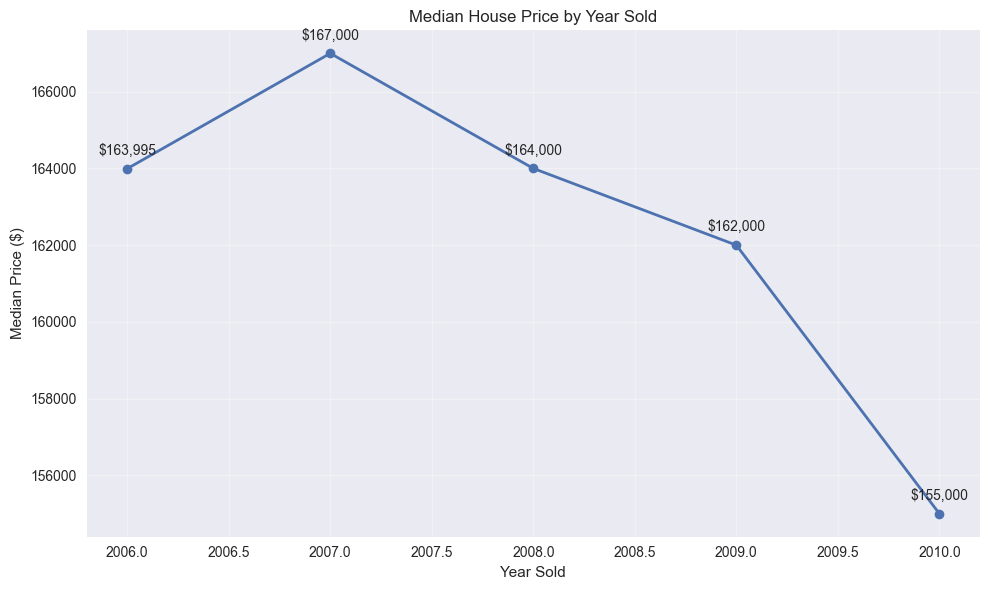

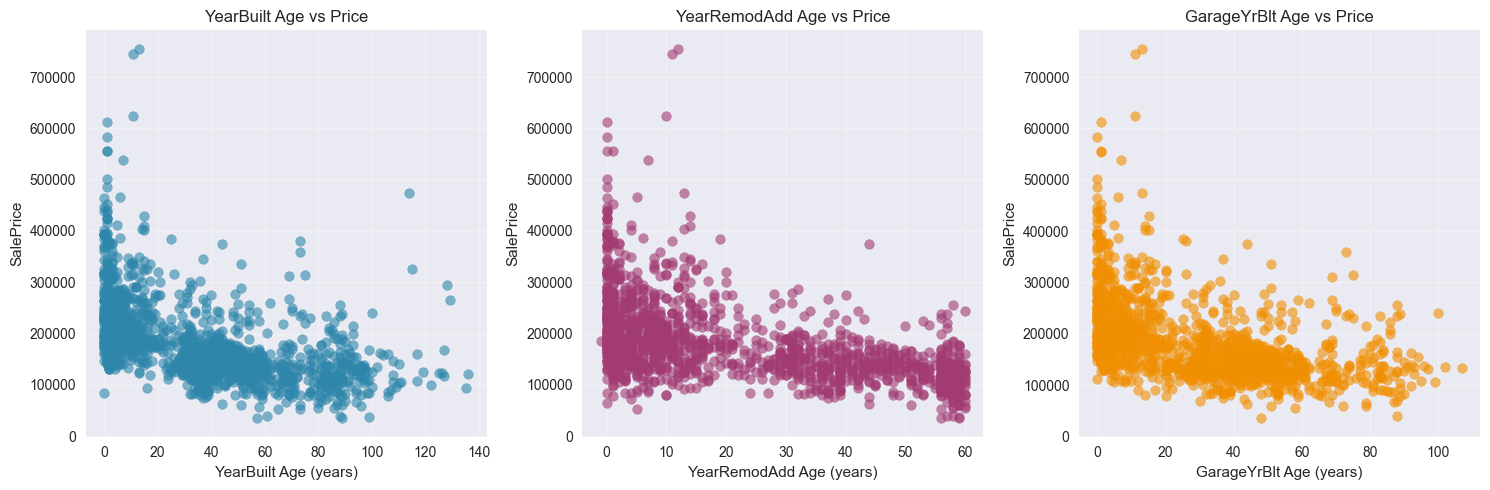

In [15]:
# 1. Get feature types from your dataset
feature_types = get_feature_types(df)

# 2. Extract temporal features
temporal_features = feature_types['temporal']

# 3. Call your temporal analysis function
if temporal_features:
    analyze_temporal_trends(df, temporal_features)
else:
    print("No temporal features found to analyze.")
